# This notebook does a chained fit of 2-point and Feynman-Hellman

In [49]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [50]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [51]:
import pickle

In [52]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [53]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [54]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)



In [55]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and Feynman-Hellman samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])

<ipython-input-55-f44cb866a54c>:17: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-55-f44cb866a54c>:18: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
<ipython-input-55-f44cb866a54c>:19: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))
<ipython-input-55-f44cb866a54c>:21: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


In [56]:
# Create functions to extract the necessary fit-parameters for each function, and to insert priors specific to a function into a more complete parameter list
# Create methods for forming a parameter subset for each of the 3 functions: 2-point, 3-point, Feynman-Hellman
def param_2pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    return sub_p
      
def param_3pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    return sub_p

def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

In [57]:
# Now, create some methods for setting the full posterior, both used and unused variables 
def posterior_2pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = partial_post['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = partial_post['Ztilde{}'.format(k)]
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
        
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post          
              
def posterior_3pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post
              
def posterior_FH(partial_post, full_prior):
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = full_prior['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = full_prior['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)] 
        
    for k in range(1, num_states_FH - 1):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):    
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
                        
    full_post['Z_FHmax'] = partial_post['Z{}'.format(num_states_FH - 1)]
    full_post['log(FH_dEmax)'] = partial_post['log(dE{})'.format(num_states_FH - 1)]
              
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gA3_{}FHmax'.format(n)] = partial_post['gA3_{0}{1}'.format(n, num_states_FH-1)]
        full_post['gV4_FHmax{}'.format(n)] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gV4_{}FHmax'.format(n)] = partial_post['gV4_{0}{1}'.format(n, num_states_FH-1)]
        
    full_post['gA3_FHmaxFHmax'] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
    full_post['gV4_FHmaxFHmax'] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
      
    return full_post
    

In [58]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [59]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [60]:
num_states_FH = 1 # The number of states that the Feynman-Hellman sum needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))


def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [61]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d
    

#### Chained-fit

In [82]:
# Try doing a 2-point-FH chained fit

# Test: try fitting the Feynamn Hellman fit individually

num_zs = 2
num_states_FH = 2

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_states_FH)
dEvals = np.array([None]*(num_states_FH - 1))

energyvals[0] = tp['E0'].mean
for k in range(1, num_states_FH):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_states_FH): #num_zs
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    
# Set the "garbage can" for the Feynman Hellman fit
#tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 
#tp['Z_FHmax'] = gv.gvar(0.0008, 0.0004)

for n in range(num_states_FH): #num_zs
    for m in range(num_states_FH): #num_zs
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
        if n == m and n < num_states_FH-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

#tp['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
#tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#for n in range(num_states_FH-1):
    #tp['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
    #tp['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
    #tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)

In [83]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(5, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(5,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [16]    Q = 0.39    logGBF = 369.05

Parameters:
             E0       0.660642 +- 0.00241573             [     0.67 +- 0.02 ]  
             Z0   0.000756651 +- 8.21891e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286505 +- 3.7085e-05             [   0.003 +- 0.003 ]  
             Z1   0.000793333 +- 2.94221e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00536789 +- 0.000294539             [        0 +- 0.01 ]  
       log(dE1)        -0.68562 +- 0.0575436             [  -0.97551 +- 0.7 ]  
         gA3_00                 1.25 +- 0.15             [     1.25 +- 0.15 ]  
         gV4_00                 1.07 +- 0.07             [     1.07 +- 0.07 ]  
         gA3_01                       1 +- 2             [           1 +- 2 ]  
         gV4_01                       0 +- 2             [           0 +- 2 ]  
         gA3_10                       1 +- 2             [           1 +- 2 ]  
         gV4_10               

In [84]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv')) #chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 48.55
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 48.55

Parameters:
             E0       0.660761 +- 0.00231095             [     0.660642 +- 0.00241573 ]  
             Z0   0.000757071 +- 7.87435e-06             [ 0.000756651 +- 8.21891e-06 ]  
        Ztilde0    0.00286706 +- 3.56621e-05             [   0.00286505 +- 3.7085e-05 ]  
             Z1   0.000795553 +- 2.92137e-05             [ 0.000793333 +- 2.94221e-05 ]  
        Ztilde1    0.00540073 +- 0.000289833             [  0.00536789 +- 0.000294539 ]  
       log(dE1)       -0.678924 +- 0.0565431             [      -0.68562 +- 0.0575436 ]  
         gA3_00         1.26296 +- 0.0164795             [               1.25 +- 0.15 ]  
         gV4_00         1.02699 +- 0.0113791             [               1.07 +- 0.07 ]  
         gA3_01         -0.185764 +- 1.41454             [                     1 +- 2 ]  
         gV4_01         0.0250389 +- 1.41438             [                     0 +- 2 ]  
         g

In [85]:
current_posterior = open('chained_2pt_FH_Final.obj', 'wb') #485.81, 48.245
pickle.dump(post_CFH, current_posterior)
current_posterior.close()

In [86]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_CFH)
C2ptPS_model = C_2pt_PS(tsep_model, post_CFH)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

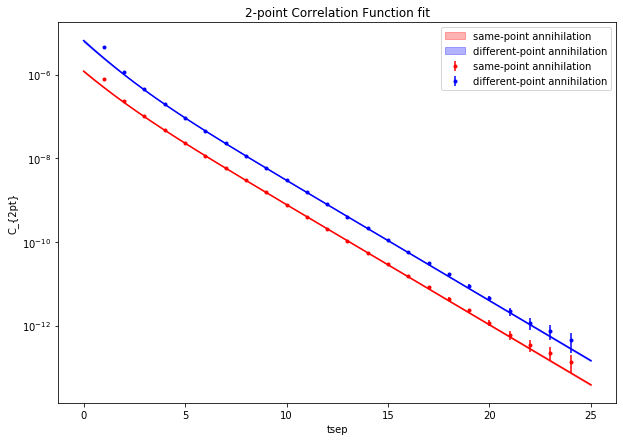

<Figure size 432x288 with 0 Axes>

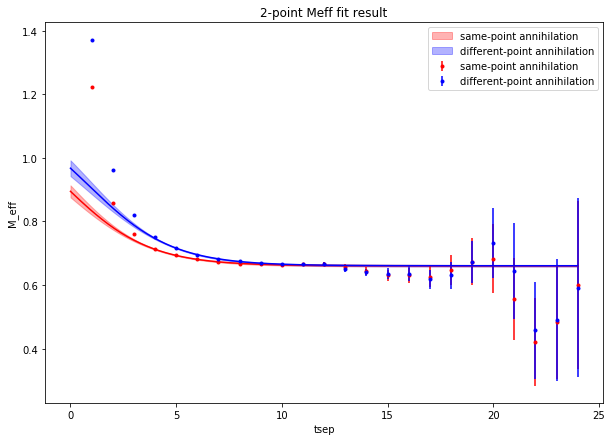

<Figure size 432x288 with 0 Axes>

In [87]:
# Plot the fits
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])



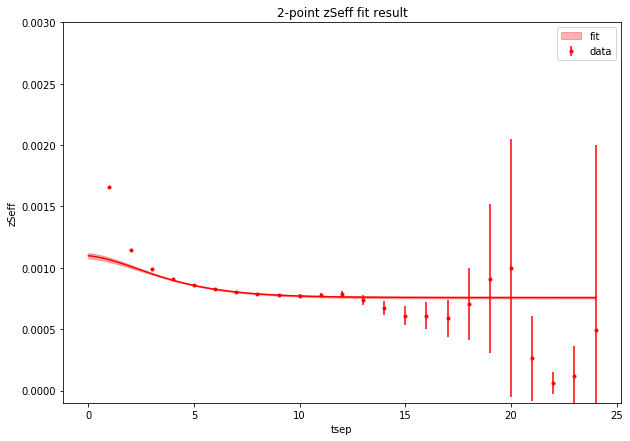

<Figure size 432x288 with 0 Axes>

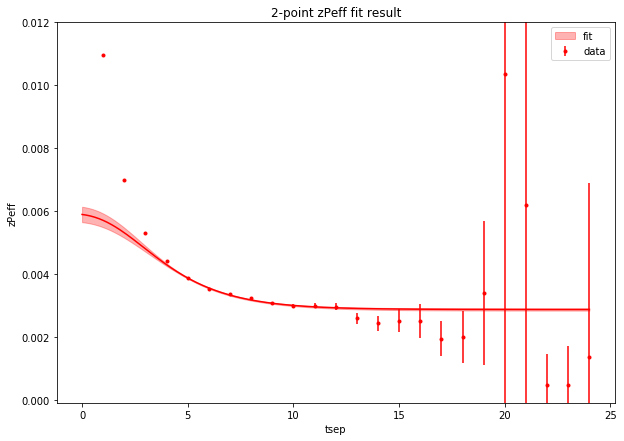

<Figure size 432x288 with 0 Axes>

In [88]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

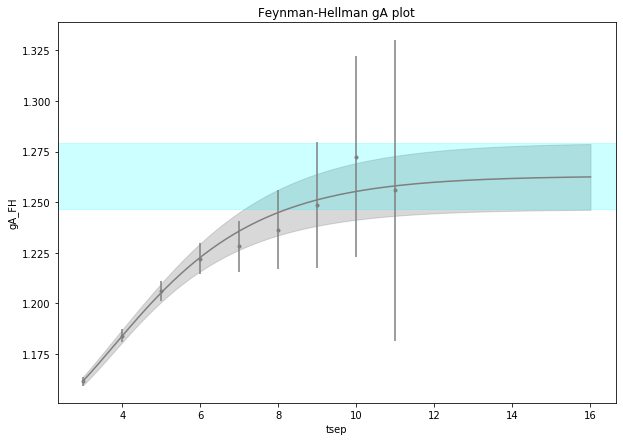

<Figure size 432x288 with 0 Axes>

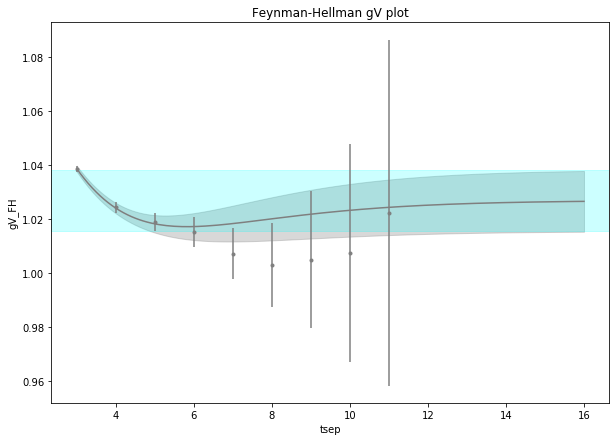

<Figure size 432x288 with 0 Axes>

In [89]:
# And finally, plot the Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_CFH)
CFH_V4_model = C_FH_V4(t_FH_model, post_CFH)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFH['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFH['gV4_00'], ydat_error=y_CFH_V4_err)



## Now, compare results for various sample sizes and tau-cuts